# RESNET

## Model

In [ ]:
import os
import time
import psutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import sys
sys.path.append("../3D-CNN-PyTorch")
from models import resnet

import nibabel as nib
import pandas as pd


LABEL_MAP = {
    'Good': 1,
    'Acceptable': 0,
    'Poor': 0,
    'Missed': 0
}

class MRIDataset(Dataset):
    def __init__(self, label_csv="../preliminary_automatic_segmentations_quality_scores.csv"):
        self.image_root = "../images"
        self.mask_root = "../segmentations/automatic"

        # Load labels
        df = pd.read_csv(label_csv)
        self.labels = {}
        for _, row in df.iterrows():
            pid = row['patient_id']
            score1 = LABEL_MAP.get(row['expert_1_qs'], 0)
            score2 = LABEL_MAP.get(row['expert_2_qs'], 0)
            label = 1 if (score1 == 1 and score2 == 1) else 0
            self.labels[pid] = label

        self.patient_ids = []
        self.missing_patients = []

        all_patients = [pid for pid in os.listdir(self.image_root)
                        if pid.startswith("DUKE_") and os.path.isdir(os.path.join(self.image_root, pid))]

        for pid in sorted(all_patients):
            if pid not in self.labels:
                continue

            image_path = os.path.join(self.image_root, pid, f"{pid}_0001_n4_denoised_resampled_padded.nii.gz")
            mask_path = os.path.join(self.mask_root, f"{pid}_processed.nii.gz")

            if os.path.exists(image_path) and os.path.exists(mask_path):
                self.patient_ids.append(pid)
            else:
                self.missing_patients.append(pid)

        print(f"[INFO] Valid DUKE patients with data: {len(self.patient_ids)}", flush=True)
        if self.missing_patients:
            print(f"[WARN] Skipped {len(self.missing_patients)} patients due to missing files:")
            for pid in self.missing_patients:
                print(f"  - Missing files for {pid}", flush=True)

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]

        image_path = os.path.join(self.image_root, patient_id, f"{patient_id}_0001_n4_denoised_resampled_padded.nii.gz")
        mask_path = os.path.join(self.mask_root, f"{patient_id}_processed.nii.gz")

        image = nib.load(image_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        # Normalize image
        image = (image - image.min()) / (image.max() - image.min() + 1e-8)

        # Stack image + mask as 2 channels
        data = np.stack([image, mask], axis=0)
        tensor = torch.tensor(data, dtype=torch.float32)

        label = torch.tensor(self.labels[patient_id], dtype=torch.float32)

        if idx % 10 == 0:
            print(f"[DATA] Loaded {patient_id} | Shape: {tensor.shape}", flush=True)

        return tensor, label

# ---------- Model ----------
def generate_model():
    print("[MODEL] Initializing ResNet model...", flush=True)
    model = resnet.generate_model(
        model_depth=50,
        n_input_channels=2,
        n_classes=1,
        conv1_t_size=7,
        conv1_t_stride=1,
        no_max_pool=False,
        shortcut_type='B',
        widen_factor=1.0
    )
    print("[MODEL] Model initialized.", flush=True)
    return model

# ---------- Training ----------
def train_single_gpu():
    print("[MAIN] Starting training script...", flush=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[MAIN] Using device: {device}", flush=True)

    print("[DATA] Loading dataset...", flush=True)
    full_dataset = MRIDataset()

    print("[DATA] Splitting into train/val sets...", flush=True)
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    print(f"[DATA] Train size: {train_size}, Val size: {val_size}", flush=True)

    print("[DATA] Initializing dataloaders...", flush=True)
    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    print("[DATA] Dataloaders ready.", flush=True)

    print("[MODEL] Generating model...", flush=True)
    model = generate_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()

    torch.backends.cudnn.benchmark = True
    start_time = time.time()

    num_epochs = 10  # ✅ Fixed indentation

    print("[TRAIN] Starting training loop...", flush=True)
    for epoch in range(num_epochs):
        print(f"\n[TRAIN] === Epoch {epoch+1}/{num_epochs} ===", flush=True)
        torch.cuda.reset_peak_memory_stats()
        model.train()

        for i, (inputs, labels) in enumerate(train_loader):
            batch_start = time.time()
            print(f"[TRAIN] --- Batch {i} ---", flush=True)
            inputs, labels = inputs.to(device), labels.to(device).view(-1)

            outputs = model(inputs).view(-1)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            try:
                loss.backward()
            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("[ERROR] CUDA out of memory during backward pass.", flush=True)
                    exit(1)
                else:
                    raise

            optimizer.step()

            preds = torch.sigmoid(outputs).detach().cpu().numpy()
            targets = labels.detach().cpu().numpy()
            print(f"[TRAIN][Epoch {epoch+1}][Batch {i:03d}] Loss: {loss.item():.4f} | Preds: {np.round(preds, 2)} | Targets: {targets}", flush=True)
            print(f"[TRAIN] Batch {i} complete. Time: {time.time() - batch_start:.2f}s\n", flush=True)

        # ---------- Validation ----------
        print(f"[VAL] Starting validation for epoch {epoch+1}...", flush=True)
        model.eval()
        val_losses = []
        val_correct = 0
        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_loader):
                if i % 10 == 0:
                    print(f"[VAL] Batch {i}", flush=True)
                inputs, labels = inputs.to(device), labels.to(device).view(-1)
                outputs = model(inputs).view(-1)
                loss = criterion(outputs, labels)
                val_losses.append(loss.item())

                preds = (torch.sigmoid(outputs) > 0.5).long()
                val_correct += (preds == labels.long()).sum().item()

        val_loss = np.mean(val_losses)
        val_acc = val_correct / len(val_dataset)
        print(f"[VAL][Epoch {epoch+1}] Loss: {val_loss:.4f} | Accuracy: {val_acc:.4f}", flush=True)

        # GPU Memory Reporting
        peak_mem = torch.cuda.max_memory_allocated() / 1e6  # MB
        print(f"[RESOURCE][Epoch {epoch+1}] GPU Peak Memory: {peak_mem:.2f} MB", flush=True)

        # Save checkpoint
        os.makedirs("checkpoints", exist_ok=True)
        checkpoint_path = f"checkpoints/resnet_single_gpu_epoch{epoch+1}.pth"
        torch.save(model.state_dict(), checkpoint_path)
        print(f"[SAVE] Model checkpoint saved to '{checkpoint_path}'", flush=True)

    total_time = time.time() - start_time
    print(f"[TIME] Total training time: {total_time:.2f} seconds", flush=True)


# ---------- Entry Point ----------
if __name__ == "__main__":
    print("[MAIN] Calling train_single_gpu()...", flush=True)
    train_single_gpu()


## Parsing + Plotting Output

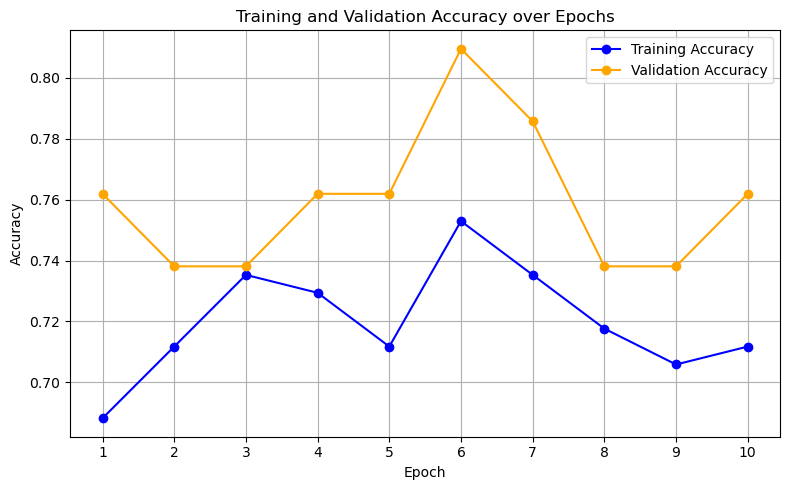

In [8]:
import re
import matplotlib.pyplot as plt

# Load log text
log_path = "output_11963112.txt"
with open(log_path, "r") as file:
    log_text = file.read()

# Extract validation accuracy and epoch number
val_acc_pattern = r"\[VAL\]\[Epoch (\d+)\] Loss: [\d\.]+ \| Accuracy: ([\d\.]+)"
val_results = re.findall(val_acc_pattern, log_text)
val_epochs = [int(e) for e, _ in val_results]
val_accs = [float(acc) for _, acc in val_results]

# Extract training accuracy per epoch by parsing predictions and targets
train_pattern = r"\[TRAIN\]\[Epoch (\d+)\]\[Batch \d+\] Loss: [\d\.]+ \| Preds: \[([\d\. ]+)\] \| Targets: \[([\d\. ]+)\]"

train_data = re.findall(train_pattern, log_text)

# Organize data by epoch
from collections import defaultdict

train_correct = defaultdict(int)
train_total = defaultdict(int)

for epoch, preds_str, targets_str in train_data:
    epoch = int(epoch)
    preds = list(map(float, preds_str.strip().split()))
    targets = list(map(float, targets_str.strip().split()))

    # Convert predicted probabilities to binary predictions (>= 0.5 is class 1)
    preds_binary = [1 if p >= 0.5 else 0 for p in preds]
    targets_binary = [int(t) for t in targets]

    correct = sum(p == t for p, t in zip(preds_binary, targets_binary))
    total = len(targets_binary)

    train_correct[epoch] += correct
    train_total[epoch] += total

# Compute accuracy per epoch
train_epochs = sorted(train_correct.keys())
train_accs = [train_correct[e] / train_total[e] for e in train_epochs]

# Plot both training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(train_epochs, train_accs, marker="o", label="Training Accuracy", color="blue")
plt.plot(val_epochs, val_accs, marker="o", label="Validation Accuracy", color="orange")
plt.title("Training and Validation Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(train_epochs)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()